In [1]:
!pip install d2l==1.0.0-beta0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.8 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616821 sha256=f0589ffc37ca850ccb8e72bc8d8b1624431a42b63e496dc671cfa42baf2235c2
  Stored in directory: /root/.cache/pip/wheels/b3/50/6c/0a82c1358b4da2dbd9c1bb17e0f89467db32812ab236dbf6d5
Successfully built gym
  Attempting uninstal

Khi thiết kế các mạng ngày càng sâu, ta cần hiểu việc thêm các tầng sẽ tăng độ phức tạp và khả năng biểu diễn của mạng như thế nào. Quan trọng hơn là khả năng thiết kế các mạng trong đó việc thêm các tầng vào mạng chắc chắn sẽ làm tăng tính biểu diễn thay vì chỉ tạo ra một chút khác biệt. Để làm được điều này, chúng ta cần một chút lý thuyết.

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 8.6.1. Các lớp hàm số

Coi $\mathcal{F}$ là một lớp các hàm mà một kiến trúc mạng cụ thể (cùng với tốc độ học và các siêu tham số khác) có thể đạt được. Nói cách khác, với mọi hàm số $f \in \mathcal{F}$, luôn tồn tại một số tập tham số $W$ có thể tìm được bằng việc huấn luyện trên một tập dữ liệu phù hợp. Giả sử $f^*$ là hàm cần tìm. Sẽ rất thuận lợi nếu hàm này thuộc tập $\mathcal{F}$, nhưng thường không may mắn như vậy. Thay vào đó, ta sẽ cố gắng tìm các hàm số $f^*_\mathcal{F}$ tốt nhất có thể trong tập $\mathcal{F}$.

Ví dụ, có thể thử tìm $f^*_\mathcal{F}$ bằng cách giải bài toán tối ưu sau:
$$
f^*_\mathcal{F} \stackrel{\mathrm{def}}{=} \mathop{\mathrm{argmin}}_f L(\mathbf{X}, \mathbf{y}, f) \text{ subject to } f \in \mathcal{F}.
$$

Khá hợp lý khi giả sử rằng nếu thiết kế một kiến trúc khác $\mathcal{F}'$ mạnh mẽ hơn thì sẽ đạt được kết quả tốt hơn. Nói cách khác, ta kỳ vọng hàm số $f^*_{\mathcal{F}'}$ sẽ “tốt hơn” $f^*_{\mathcal{F}}$. Tuy nhiên, nếu $\mathcal{F} \not\subseteq \mathcal{F}'$, thì không khẳng định được  $f^*_{\mathcal{F}'}$ “tốt hơn” $f^*_{\mathcal{F}}$. Trên thực tế, $f^*_{\mathcal{F}'}$ có thể còn tệ hơn. Và đây là trường hợp thường xuyên xảy ra — việc thêm các tầng không phải lúc nào cũng tăng tính biểu diễn của mạng mà đôi khi còn tạo ra những thay đổi rất khó lường.

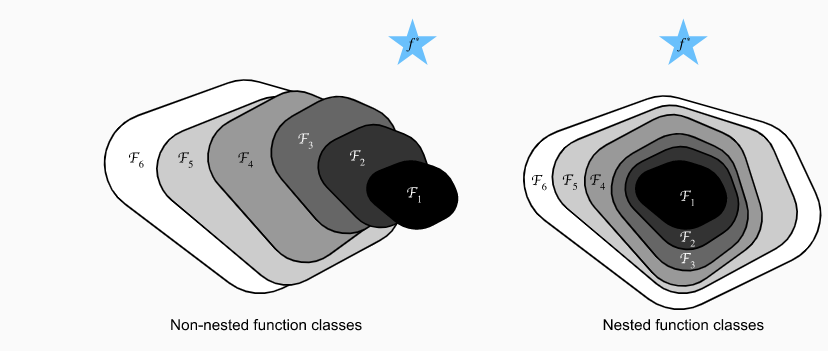

Chỉ khi các lớp hàm lớn hơn chứa các lớp nhỏ hơn, thì mới đảm bảo rằng việc tăng thêm các tầng sẽ tăng khả năng biểu diễn của mạng. Đây là câu hỏi mà He và các cộng sự đã suy nghĩ khi nghiên cứu các mô hình thị giác sâu năm 2016. Ý tưởng trọng tâm của ResNet là mỗi tầng được thêm vào nên có một thành phần là hàm số đồng nhất. Điều này có nghĩa rằng, nếu ta huấn luyện tầng mới được thêm vào thành một ánh xạ đồng nhất $f(x)=x$, thì mô hình mới sẽ hiệu quả ít nhất bằng mô hình ban đầu. Vì tầng được thêm vào có thể khớp dữ liệu huấn luyện tốt hơn, dẫn đến sai số huấn luyện cũng nhỏ hơn. Tốt hơn nữa, hàm số đồng nhất nên là hàm đơn giản nhất trong một tầng thay vì hàm null $f(x)=0$.

Cách suy nghĩ này khá trừu tượng nhưng lại dẫn đến một lời giải đơn giản đáng ngạc nhiên, một khối phần dư (residual block). Với ý tưởng này, [He et al., 2016a] đã chiến thắng cuộc thi Nhận dạng Ảnh ImageNet năm 2015. Thiết kế này có ảnh hưởng sâu sắc tới việc xây dựng các mạng nơ-ron sâu.

# 8.6.2. Khối phần dư

Bây giờ, hãy tập trung vào mạng nơ-ron dưới đây. Ký hiệu đầu vào là $x$. Giả sử ánh xạ lý tưởng muốn học được là $f(x)$, và được dùng làm đầu vào của hàm kích hoạt. Phần nằm trong viền nét đứt bên trái phải khớp trực tiếp với ánh xạ $f(x)$. Điều này có thể không đơn giản nếu chúng ta không cần khối đó và muốn giữ lại đầu vào $x$. Khi đó, phần nằm trong viền nét đứt bên phải chỉ cần tham số hoá độ lệch khỏi giá trị $x$, bởi vì ta đã trả về $x+f(x)$. Trên thực tế, ánh xạ phần dư thường dễ tối ưu hơn, vì chỉ cần đặt $f(x)=0$. Nửa bên phải hình dưới mô tả khối phần dư cơ bản của ResNet. Về sau, những kiến trúc tương tự đã được đề xuất cho các mô hình chuỗi (sequence model), sẽ đề cập ở chương sau.

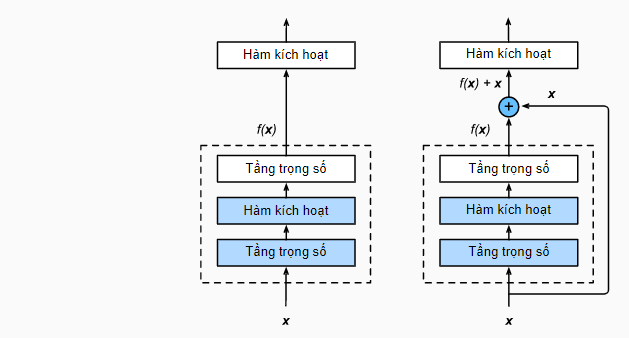

ResNet có thiết kế tầng tích chập  $3×3$ giống VGG. Khối phần dư có hai tầng tích chập $3×3$ với cùng số kênh đầu ra. Mỗi tầng tích chập được theo sau bởi một tầng chuẩn hóa theo batch và một hàm kích hoạt ReLU. Ta đưa đầu vào qua khối phần dư rồi cộng với chính nó trước hàm kích hoạt ReLU cuối cùng. Thiết kế này đòi hỏi đầu ra của hai tầng tích chập phải có cùng kích thước với đầu vào, để có thể cộng lại với nhau. Nếu muốn thay đổi số lượng kênh hoặc sải bước trong khối phần dư, cần thêm một tầng tích chập $1×1$ để thay đổi kích thước đầu vào tương ứng ở nhánh ngoài. Hãy cùng xem đoạn mã bên dưới.

In [3]:
class Residual(nn.Module):  
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X                
        return F.relu(Y)

Đoạn mã này tạo ra hai loại mạng: một loại cộng đầu vào vào đầu ra trước khi áp dụng hàm phi tuyến ReLU (khi `use_1x1conv=True`), còn ở loại thứ hai chúng ta thay đổi số kênh và độ phân giải bằng một tầng tích chập $1×1$ trước khi thực hiện phép cộng. Hình dưới minh họa điều này:

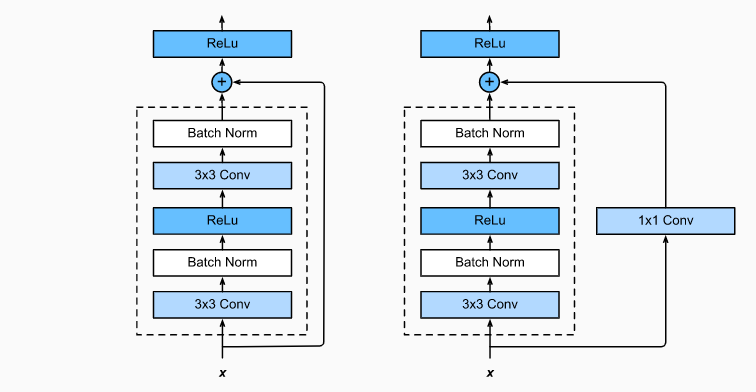

Bây giờ hãy xem xét một tình huống trong đó đầu vào và đầu ra có cùng hình dạng, trong đó $1 \times 1$ tích chập là không cần thiết.

In [4]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 3, 6, 6])

Chúng ta cũng có thể giảm một nửa kích thước chiều cao và chiều rộng của đầu ra trong khi tăng số kênh.

In [5]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

# 8.6.3. Mô hình ResNet

Hai tầng đầu tiên của ResNet giống hai tầng đầu tiên của GoogLeNet: tầng tích chập $7×7$ với 64 kênh đầu ra và sải bước 2, theo sau bởi tầng gộp cực đại $3×3$ với sải bước 2. Sự khác biệt là trong ResNet, mỗi tầng tích chập theo sau bởi tầng chuẩn hóa theo batch.

In [7]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

GoogLeNet sử dụng bốn mô-đun được tạo thành từ các khối Inception. ResNet sử dụng bốn mô-đun được tạo thành từ các khối phần dư có cùng số kênh đầu ra. Mô-đun đầu tiên có số kênh bằng số kênh đầu vào. Vì trước đó đã sử dụng tầng gộp cực đại với sải bước 2, nên không cần phải giảm chiều cao và chiều rộng ở mô-đun này. Trong các mô-đun sau, khối phần dư đầu tiên nhân đôi số kênh, đồng thời giảm một nửa chiều cao và chiều rộng.

Bây giờ ta sẽ lập trình mô-đun này. Chú ý rằng mô-đun đầu tiên được xử lý khác một chút.

In [8]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

Sau đó, chúng ta thêm tất cả các mô-đun vào ResNet. Ở đây, hai khối còn lại được sử dụng cho mỗi mô-đun. Cuối cùng, giống như GoogLeNet, chúng ta thêm một lớp tổng hợp trung bình toàn cầu, theo sau là đầu ra của lớp được kết nối đầy đủ.

In [9]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

Có 4 tầng tích chập trong mỗi mô-đun (không tính tầng tích chập  $1×1$). Cộng thêm tầng tích chập đầu tiên và tầng kết nối đầy đủ cuối cùng, mô hình có tổng cộng 18 tầng. Do đó, mô hình này thường được gọi là ResNet-18. Có thể thay đổi số kênh và các khối phần dư trong mô-đun để tạo ra các mô hình ResNet khác nhau, ví dụ mô hình 152 tầng của ResNet-152. Mặc dù có kiến trúc lõi tương tự như GoogLeNet, cấu trúc của ResNet đơn giản và dễ sửa đổi hơn. Tất cả các yếu tố này dẫn đến sự phổ cập nhanh chóng và rộng rãi của ResNet. Hình dưới là sơ đồ đầy đủ của ResNet-18.

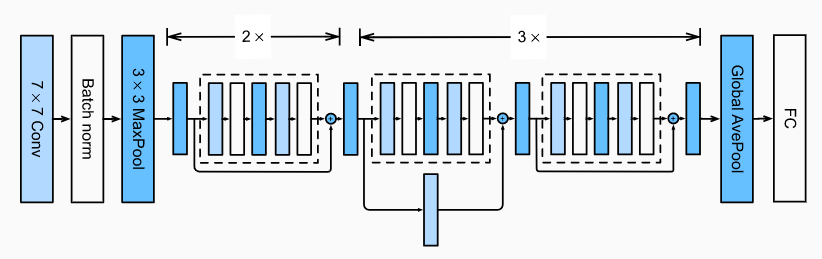

Trước khi đào tạo ResNet, hãy quan sát cách hình dạng đầu vào thay đổi trên các mô-đun khác nhau trong ResNet. Như trong tất cả các kiến ​​trúc trước đó, độ phân giải giảm trong khi số lượng kênh tăng lên cho đến điểm mà lớp tổng hợp trung bình toàn cầu tổng hợp tất cả các features.

In [10]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


# 8.6.4. Training

Chúng tôi đào tạo ResNet trên bộ dữ liệu Fashion-MNIST, giống như trước đây. ResNet là một kiến ​​trúc khá mạnh mẽ và linh hoạt. Biểu đồ nắm bắt tổn thất đào tạo và xác thực minh họa một khoảng cách đáng kể giữa cả hai biểu đồ, với tổn thất đào tạo thấp hơn đáng kể. Đối với một mạng có tính linh hoạt này, nhiều dữ liệu đào tạo hơn sẽ mang lại lợi ích đáng kể trong việc thu hẹp khoảng cách và cải thiện độ chính xác.

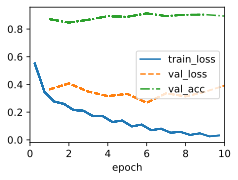

In [11]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)